#Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Change directory to allow imports


In [2]:
import os
os.chdir("/content/gdrive/My Drive/CMPT 419 720 Project/")
!ls

'=2.0.1'
 BoxDist24_GT
 BoxDist24_TrackRCNN_Training
 BoxDist31_GT
 BoxDist31_TrackRCNN_Training
 cmpt419_mono_dept_esitmation_poster_v5.pdf
'CMPT419 Project Report.gdoc'
 FairMOT
 FairMOT.ipynb
 MDE_Experiments
'Milestone Report 1.gdoc'
'Milestone Report 2.gdoc'
 MonoDepthEstimation_v0.1
 output
 poster.gdoc
 References
 sceneflow
'synthetic data'
 testing
 trackr-cnn
 TrackRCNN
 TrackR-CNN
 trackr-cnn-v2
'TrackR-CNN x BoxDist24'
'TrackR-CNN x BoxDist31'
'TrackR-CNN x BoxDist31 Video Outs'
 training
'Weekly Briefings'


##Import Libraries

In [3]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

import pycocotools

##Set Directory

In [4]:
BASE_DIR = '/content/gdrive/My Drive/CMPT 419 720 Project/'
TESTING_DIR = os.path.join(BASE_DIR, 'testing')
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

#BoxDist31

##Network

Network Definition

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BBoxDistNet_Agnostic(nn.Module):
  def __init__(self):
    super(BBoxDistNet_Agnostic, self).__init__()

    self.fc_net = nn.Sequential(
      nn.Linear(24, 18),
      nn.LayerNorm(18),
      nn.LeakyReLU(0.01, inplace=True),
      nn.Linear(18, 18),
      nn.LayerNorm(18),
      nn.LeakyReLU(0.01, inplace=True),
      nn.Linear(18, 3),
    )
  def forward(self, x):
    x = self.fc_net(x)
    return x

net = BBoxDistNet_Agnostic().cuda()

criterion = nn.L1Loss()

Load Pretrained Model

In [6]:
net = torch.load(os.path.join(OUTPUT_DIR, 'bbox24_1240_2783_100_multi.pt')).cuda()

#Testing

In [7]:
set_names = ['0002', '0006', '0007', '0008', '0010', '0013', '0014', '0016', '0018']

In [8]:
import math

def dist(xyz):
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    return math.sqrt(x**2+y**2+z**2)

##predict displacement with forward euler
def dynamic_disp(v1, v2, a1, a2, t=0.1, h=0.001):
  ad = (a2-a1)/t
  d = 0
  v = v1
  a = a1
  for t in range(int(t/h)):
    a = a + h*ad
    v = v + h*a
    d += v*h + 0.5*a*h**2
  return d

##Load Test GT Labels (Expected Outputs)

In [9]:
def load_gt_dists(set_names):
  gt_len = 0
  annotations = {}
  kitti_anno_dir = os.path.join(TESTING_DIR, 'label_02')
  tracking_anno_dir = os.path.join(TESTING_DIR, 'tracking_data/segmentations')

  for set_name in set_names:
    kitti_anno_file = os.path.join(kitti_anno_dir, set_name+'.txt')
    tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
    records = {}

    tracking_anno = open(tracking_anno_file, 'r')
    tracking_lines = tracking_anno.readlines()
    line = tracking_lines[0]
    e = line.split(' ')
    height = int(e[3])
    width = int(e[4])

#Load Kitti Annotations
    kitti_anno = open(kitti_anno_file, 'r')
    kitti_lines = kitti_anno.readlines()
    for line in kitti_lines:
      e = line.split(' ')
      class_name = e[2]
      trunc = float(e[3])
      if (class_name != 'Car' and class_name != 'Pedestrian') or trunc > 0: #data exclusion
        continue
      frame = int(e[0])
      obj_id = int(e[1])
      if frame not in records.keys():
        records[frame] = {}
      if obj_id not in records[frame].keys():
        records[frame][obj_id] = {}
      records[frame][obj_id] = {
          'bbox': [float(e[6])/width, float(e[7])/height, float(e[8])/width, float(e[9])/height],
          'target': torch.from_numpy(np.array([float(e[13]), float(e[14]), float(e[15])])),
          'centre': [((float(e[6])+(float(e[8])-float(e[6]))/2)-(width/2))/width, ((float(e[7])+(float(e[9])-float(e[7]))/2)-(height/2))/height]
      }
      gt_len += 1
    annotations[set_name] = records
  print('GT has %d object instances' %(gt_len))
  return annotations

In [10]:
gt_obj_dists = load_gt_dists(set_names)

GT has 10846 object instances


##Load Track-RCNN Detections & Frame IMU Data (Inputs)

In [11]:
from pycocotools import mask as cocomask

def load_track_imu(set_names):
  pred_len = 0
  annotations = {}
  tracking_anno_dir = os.path.join(TESTING_DIR, 'tracking_data/segmentations')
  detection_anno_dir = os.path.join(TESTING_DIR, 'tracking_data/detections')
  gps_anno_dir = os.path.join(TESTING_DIR, 'oxts')

  for set_name in set_names:
    tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
    detection_anno_file = os.path.join(detection_anno_dir, set_name+'.txt')
    gps_anno_file = os.path.join(gps_anno_dir, set_name+'.txt')
    records = {}

#Load GPS Annotations
    gps_anno = open(gps_anno_file, 'r')
    gps_lines = gps_anno.readlines()
    gps = {}
    for frame, line in enumerate(gps_lines):
      e = line.split(' ')
      v = [float(e[8]), float(e[9]), float(e[10])]
      a = [float(e[11]), float(e[12]), float(e[13])]
      gps[frame] = {
          'v': v,
          'a': a,
      }
    
    tracking_anno = open(tracking_anno_file, 'r')
    tracking_lines = tracking_anno.readlines()
    for line in tracking_lines:
      e = line.split(' ')
      frame = int(e[0])
      if frame not in gps.keys():
        continue
      class_id = int(e[2])
      if class_id == 1:
        class_id = 0
      elif class_id == 2:
        class_id = 3
      obj_id = int(e[1])-1
      if frame not in records.keys():
        records[frame] = {}
        records[frame]['objs'] = {}
      height = int(e[3])
      width = int(e[4])
      records[frame]['height'] = height
      records[frame]['width'] = width
      records[frame]['v'] = gps[frame]['v']
      records[frame]['a'] = gps[frame]['a']
      records[frame]['frame'] = frame
      rle_obj = {
          'counts': e[5],
          'size': [height, width]
      }
      #bbox = cocomask.toBbox(rle_obj) #outputs XYWH
      if obj_id not in records[frame]['objs'].keys():
        records[frame]['objs'][obj_id] = {}
      #records[frame]['objs'][obj_id]['bbox'] = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
      records[frame]['objs'][obj_id]['rle'] = e[5].rstrip()
      records[frame]['objs'][obj_id]['class_id'] = class_id

    detection_anno = open(detection_anno_file, 'r')
    detection_lines = detection_anno.readlines()
    for line in detection_lines:
      e = line.split(' ')
      frame = int(e[0])
      confidence = float(e[5])
      if frame not in records.keys():
        continue
      bbox = [float(e[1]), float(e[2]), float(e[3]), float(e[4])]
      if 0.0 in bbox or width in bbox or height in bbox:# or confidence < 0.5 :
        continue
      rle = e[9].rstrip()
      for obj_id in records[frame]['objs'].keys():
        if records[frame]['objs'][obj_id]['rle'] == rle:
          records[frame]['objs'][obj_id]['bbox'] = bbox
          break
        pred_len += 1;

    annotations[set_name] = records
  
  print('TrackR-CNN has %d object instances' %(pred_len))
  return annotations


In [12]:
tracking_imu_data = load_track_imu(set_names)

TrackR-CNN has 169695 object instances


##Construct Model Inputs


In [13]:
def make_input(frame1, frame2, delta=1):
  height = frame1['height']
  width = frame1['width']
  img_center = [width/2, height/2]
  bbox1 = [frame1['bbox'][0]/width, frame1['bbox'][1]/height, frame1['bbox'][2]/width, frame1['bbox'][3]/height]
  bbox2 = [frame2['bbox'][0]/width, frame2['bbox'][1]/height, frame2['bbox'][2]/width, frame2['bbox'][3]/height]
  xd = -dynamic_disp(frame1['v'][1], frame2['v'][1], frame1['a'][1], frame2['a'][1], delta*0.1)
  yd = -dynamic_disp(frame1['v'][2], frame2['v'][2], frame1['a'][2], frame2['a'][2], delta*0.1)
  zd = dynamic_disp(frame1['v'][0], frame2['v'][0], frame1['a'][0], frame2['a'][0], delta*0.1)
  disp = [xd, yd, zd]
  bbox1 = [frame1['bbox'][0]/width, frame1['bbox'][1]/height, frame1['bbox'][2]/width, frame1['bbox'][3]/height]
  bbox2 = [frame2['bbox'][0]/width, frame2['bbox'][1]/height, frame2['bbox'][2]/width, frame2['bbox'][3]/height]
  w1 = bbox1[2] - bbox1[0]
  w2 = bbox2[2] - bbox2[0]
  h1 = bbox1[3] - bbox1[1]
  h2 = bbox2[3] - bbox2[1]
  a1 = w1*h1
  a2 = w2*h2
  c1 = [(frame1['bbox'][0]+(w1/2)-img_center[0])/(width/2), (frame1['bbox'][1]+(h1/2)-img_center[1])/(height/2)]
  c2 = [(frame2['bbox'][0]+(w2/2)-img_center[0])/(width/2), (frame2['bbox'][1]+(h2/2)-img_center[1])/(height/2)]
  class_id = frame1['class_id']
  id_vec = [0, 0, 0, 0, 0, 0, 0]
  id_vec[class_id] = 1
  input = torch.from_numpy(np.array(bbox1 + bbox2 + disp + [w1, w2, h1, h2, a1, a2] + c1 + c2 + [w2/w1, h2/h1, a2/a1]).astype(np.float32)).cuda()
  return input

##Measure Accuracy

In [ ]:
#net = torch.load(os.path.join(OUTPUT_DIR, 'bbox31_807_1633_58.pt')).cuda()
#net = torch.load(os.path.join(OUTPUT_DIR, 'bbox24_trackrcnn.pt')).cuda()
net = torch.load(os.path.join(OUTPUT_DIR, 'bbox24_not-car_car_1697_3557_110.pt')).cuda()

###Deprecated Code

In [ ]:
def pt_dists_2D(p0, pts):
  dists = []
  for pt in pts:
    dists.append(math.sqrt((p0[0]-pt[0])**2+(p0[1]-pt[1])**2))
  return dists

def bbox_overlap_ratio(bbox0, bboxs):
  ratios = []
  area0 = (bbox0[2]-bbox0[0]) * (bbox0[3]-bbox0[1])
  for bbox in bboxs:
    x_left = max(bbox0[0], bbox[0])
    y_top = max(bbox0[1], bbox[1])
    x_right = min(bbox0[2], bbox[2])
    y_bottom = min(bbox0[3], bbox[3])
    if x_right < x_left or y_bottom < y_top:
      iou = 0.0
      ratios.append(iou)
    else:
      intersection_area = (x_right - x_left) * (y_bottom - y_top)
      bb1_area = (bbox0[2] - bbox0[0]) * (bbox0[3] - bbox0[1])
      bb2_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
      iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
      ratios.append(iou)

  return ratios

def align_input_to_gt(inputs, gts):
  input_cs = []
  gt_cs = []
  for input in inputs:
    numpy_input = input.detach().cpu().numpy()
    input_c = [numpy_input[26], numpy_input[27]]
    input_cs.append(input_c)
  for obj_id in gts.keys():
    gt_c = gts[obj_id]['centre']
    gt_cs.append(gt_c)
  
  dist_table = []
  for gt_c in gt_cs:
    dists = pt_dists_2D(gt_c, input_cs)
    dist_table.append(dists)
  dist_table = np.array(dist_table)

  alignments = [-1]*len(gts)

  input_mins = []
  gt_mins = []
  for i in range(len(inputs)):
    input_mins.append(np.argmin(dist_table[:, i]))
  for i in range(len(gts)):
    gt_mins.append(np.argmin(dist_table[i, :]))

  for i, gt_min in enumerate(gt_mins):
    if input_mins[gt_min] == i:
      alignments[i] = gt_min

  return alignments


def align_input_to_gt(inputs, gts):
  input_bboxs = []
  gt_bboxs = []
  for input in inputs:
    numpy_input = input.detach().cpu().numpy()
    input_bbox = [numpy_input[11], numpy_input[12], numpy_input[13], numpy_input[14]]
    input_bboxs.append(input_bbox)
  for obj_id in gts.keys():
    gt_bbox = gts[obj_id]['bbox']
    gt_bboxs.append(gt_bbox)
  
  ratio_table = []
  for gt_bbox in gt_bboxs:
    ratios = pt_dists_2D(gt_bbox, input_bboxs)
    ratio_table.append(ratios)
  ratio_table = np.array(ratio_table)

  alignments = [-1]*len(gts)

  input_maxs = []
  gt_maxs = []
  for i in range(len(inputs)):
    if np.max(ratio_table[:, i]) == 0:
      input_maxs.append(-2)
    else:
      input_maxs.append(np.argmax(ratio_table[:, i]))
  for i in range(len(gts)):
    if np.max(ratio_table[i, :]) == 0:
      gt_maxs.append(-2)
    else:
      gt_maxs.append(np.argmax(ratio_table[i, :]))
    
  for i, gt_max in enumerate(gt_maxs):
    if input_maxs[gt_max] == i:
      alignments[i] = gt_max

  return alignments

###Pred/Target Alignment

In [14]:
def bbox_overlap_ratio(bbox0, bboxs):
  ratios = []
  area0 = (bbox0[2]-bbox0[0]) * (bbox0[3]-bbox0[1])
  for bbox in bboxs:
    x_left = max(bbox0[0], bbox[0])
    y_top = max(bbox0[1], bbox[1])
    x_right = min(bbox0[2], bbox[2])
    y_bottom = min(bbox0[3], bbox[3])
    if x_right < x_left or y_bottom < y_top:
      iou = 0.0
      ratios.append(iou)
    else:
      intersection_area = (x_right - x_left) * (y_bottom - y_top)
      bb1_area = (bbox0[2] - bbox0[0]) * (bbox0[3] - bbox0[1])
      bb2_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
      iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
      ratios.append(iou)

  return ratios

def align_input_to_gt(inputs, gts):
  input_bboxs = []
  gt_bboxs = []
  for input in inputs:
    numpy_input = input.detach().cpu().numpy()
    input_bbox = [numpy_input[4], numpy_input[5], numpy_input[6], numpy_input[7]]
    input_bboxs.append(input_bbox)
  for obj_id in gts.keys():
    gt_bbox = gts[obj_id]['bbox']
    gt_bboxs.append(gt_bbox)
  
  ratio_table = []
  for gt_bbox in gt_bboxs:
    ratios = bbox_overlap_ratio(gt_bbox, input_bboxs)
    ratio_table.append(ratios)
  ratio_table = np.array(ratio_table)

  alignments = [-1]*len(gts)

  gt_maxs = []
  for i in range(len(gts)):
    gt_maxs.append(np.argmax(ratio_table[i, :]))
  input_maxs = []
  for i in range(len(inputs)):
    input_maxs.append(np.argmax(ratio_table[:, i]))

  for me, want in enumerate(gt_maxs):
    if input_maxs[want] == me and ratio_table[me, want] > 0.0:
      alignments[me] = want

  return alignments

###Measure

In [15]:
rmse = []
output_records = []
target_records = []
n = 0
abs_errors = []
rel_errors = []
preds = []
dists = []
net.eval()
for set_name in set_names:
  prev_data = {}
  for frame in gt_obj_dists[set_name].keys():
    if frame not in tracking_imu_data[set_name].keys():
      continue
    inputs = []
    for obj_id in tracking_imu_data[set_name][frame]['objs']:
      this_frame = tracking_imu_data[set_name][frame]
      if obj_id in prev_data.keys() and 'bbox' in this_frame['objs'][obj_id].keys():
        last_frame = prev_data[obj_id]
        if 'bbox' in last_frame['objs'][obj_id].keys():
          frame1 = {
              'v': last_frame['v'],
              'a': last_frame['a'],
              'bbox': last_frame['objs'][obj_id]['bbox'],
              'class_id': last_frame['objs'][obj_id]['class_id'],
              'height': last_frame['height'], 
              'width': last_frame['width'],
          }
          frame2 = {
              'v': this_frame['v'],
              'a': this_frame['a'],
              'bbox': this_frame['objs'][obj_id]['bbox'],
              'class_id': this_frame['objs'][obj_id]['class_id'],
          }
          delta = this_frame['frame'] - last_frame['frame']
          input = make_input(frame1, frame2, delta)
          inputs.append(input)
      prev_data[obj_id] = this_frame

    if len(inputs) == 0:
      continue

    outputs = []
    with torch.no_grad():
      for input in inputs:
        output = net(input).detach().cpu()
        outputs.append(output)
    
    frame_gt = gt_obj_dists[set_name][frame]

    alignment = align_input_to_gt(inputs, frame_gt)

    targets = []

    for obj_id in frame_gt.keys():
      targets.append(frame_gt[obj_id]['target'])
    
    for t, o in enumerate(alignment):
      if o == -1:
        continue
      output = outputs[o]
      target = targets[t]
      output_records.append(dist(output))
      target_records.append(dist(target))
      rmse.append((dist(target)-dist(output))**2)
      abs_error = abs(dist(target)-dist(output))
      rel_error = abs_error/dist(target)
      abs_errors.append(abs_error)
      rel_errors.append(rel_error)
      preds.append(dist(output))
      dists.append(dist(target))
      n += 1

print('num aligned samples: %d' %(n))
print('mean absolute error: %.3fm' %(np.mean(abs_errors)))
print('mean relative error: %.3f' %(np.mean(rel_errors)))
print('median absolute error: %.3fm' %(np.median(np.sort(abs_errors))))
print('median relative error: %.3f' %(np.median(np.sort(rel_errors))))
rmse = sum(rmse)
rmse /= n
rmse = math.sqrt(rmse)
print(rmse)

num aligned samples: 6702
mean absolute error: 3.885m
mean relative error: 0.150
median absolute error: 2.068m
median relative error: 0.104
6.2498649217990625


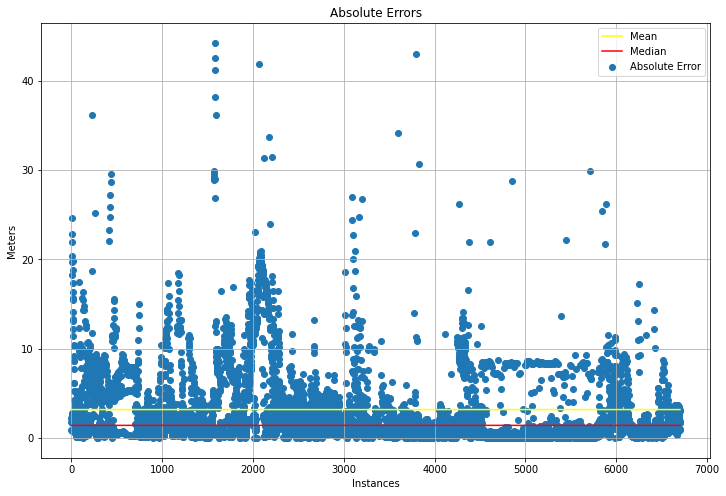

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

ns = np.array([x for x in range(n)])
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(ns, np.array(abs_errors), label='Absolute Error')
ax.plot(ns, np.array([np.mean(abs_errors)]*n), color='yellow', label='Mean')
ax.plot(ns, np.array([np.median(np.sort(abs_errors))]*n), color='red', label='Median')
ax.set(xlabel='Instances', ylabel='Meters',
       title='Absolute Errors')
ax.grid()
ax.legend()
plt.show()

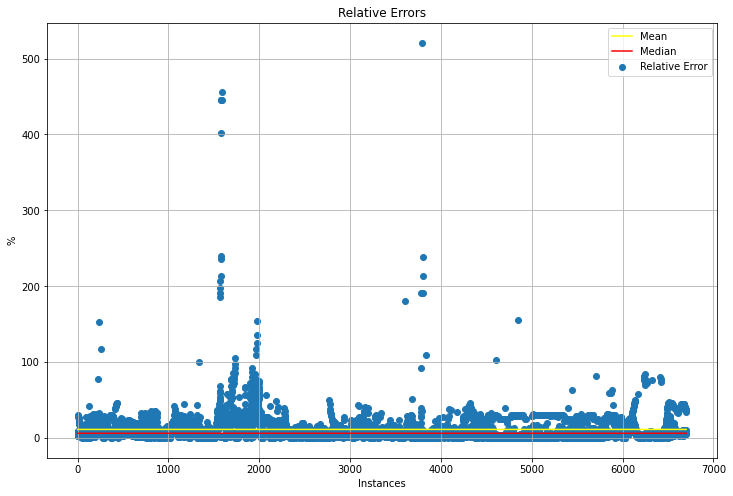

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

ns = np.array([x for x in range(n)])
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(ns, np.array(rel_errors)*100, label='Relative Error')
ax.plot(ns, np.array([np.mean(rel_errors)*100]*n), color='yellow', label='Mean')
ax.plot(ns, np.array([np.median(np.sort(rel_errors))*100]*n), color='red', label='Median')
ax.set(xlabel='Instances', ylabel='%',
       title='Relative Errors')
ax.grid()
ax.legend()
plt.show()

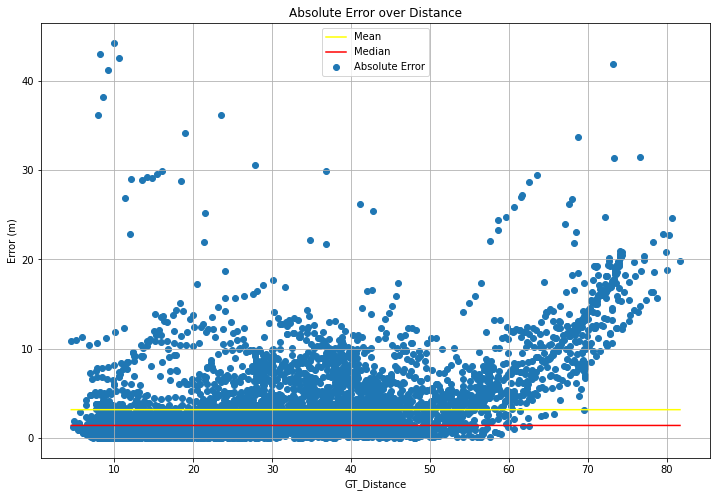

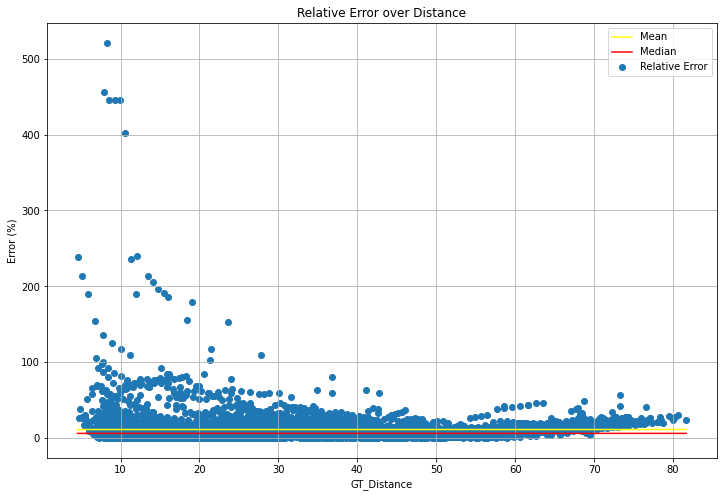

In [ ]:
ordered_abs = [x for _, x in sorted(zip(dists, abs_errors))]
ordered_rel = [x for _, x in sorted(zip(dists, rel_errors))]

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(np.sort(dists), np.array(ordered_abs), label='Absolute Error')
p = np.poly1d(np.polyfit(dists, ordered_abs, 10))
xp = np.linspace(min(dists), max(dists), len(dists))
#ax.plot(xp, p(xp), color='orange')
ax.plot(np.sort(dists), np.array([np.mean(abs_errors)]*n), color='yellow', label='Mean')
ax.plot(np.sort(dists), np.array([np.median(np.sort(abs_errors))]*n), color='red', label='Median')
ax.set(xlabel='GT_Distance', ylabel='Error (m)',
       title='Absolute Error over Distance')
ax.grid()
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(np.sort(dists), np.array(ordered_rel)*100, label='Relative Error')
p = np.poly1d(np.polyfit(dists, np.array(ordered_rel)*100, 10))
xp = np.linspace(min(dists), max(dists), len(dists))
#ax.plot(xp, p(xp), color='orange')
ax.plot(np.sort(dists), np.array([np.mean(rel_errors)*100]*n), color='yellow', label='Mean')
ax.plot(np.sort(dists), np.array([np.median(np.sort(rel_errors))*100]*n), color='red', label='Median')
ax.set(xlabel='GT_Distance', ylabel='Error (%)',
       title='Relative Error over Distance')
ax.grid()
ax.legend()
plt.show()
